In [2]:
import pandas as pd
import networkx as nx
import dowhy
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression
import numpy as np
from dowhy.causal_identifier import backdoor

C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_path = 'C:/Users/Ioannis/Documents/lucas0_train.data'
test_path = 'C:/Users/Ioannis/Documents/lucas0_test.data'
targets_path = 'C:/Users/Ioannis/Documents/lucas0_train.targets'
param_path = 'C:/Users/Ioannis/Documents/lucas0.param'


column_names_targets = ['LC']  
column_names = [
    'SMOK',
    'YF',
    'ANX',
    'PP',
    'GEN',
    'ATDSD',
    'BED',
    'CAR',
    'FTG',
    'ALG',
    'COUGH'
]



train = pd.read_csv(train_path, names= column_names,delimiter='\\s+')
test = pd.read_csv(test_path)
targets = pd.read_csv(targets_path, names=column_names_targets)
param = pd.read_csv(param_path)

data = pd.concat([train, targets], axis=1)

num_samples = data.shape[0]

# change LC variable from (-1,1) t0 (0,1) for calculations
data['LC'] =data['LC'].replace(-1, 0)

In [5]:
data

,SMOK,YF,ANX,PP,GEN,ATDSD,BED,CAR,FTG,ALG,COUGH,LC
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


## Draw Graph

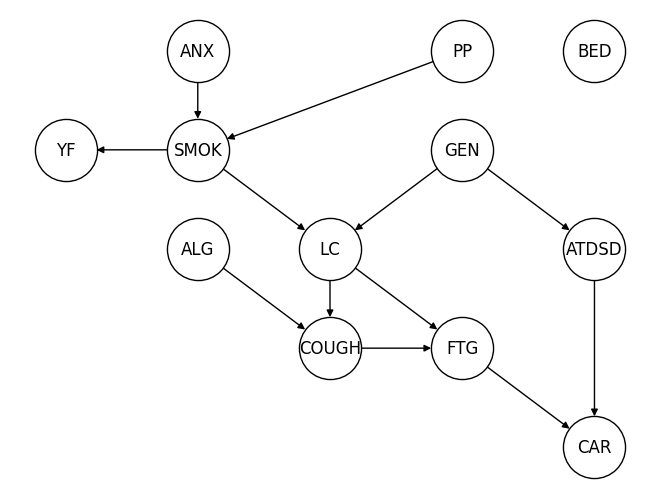

In [6]:
G = nx.DiGraph()

G.add_nodes_from(['ANX', 'PP', 'BED', 'YF', 'SMOK', 'GEN', 'ALG', 'LC', 'ATDSD', 'COUGH', 'FTG', 'CAR'])

G.add_edges_from([('ANX', 'SMOK'),
                   ('PP', 'SMOK'),
                   ('SMOK', 'YF'),
                   ('SMOK', 'LC'),
                   ('COUGH', 'FTG'),
                   ('GEN', 'LC'),
                   ('GEN', 'ATDSD'),
                   ('LC', 'FTG'),
                   ('LC', 'COUGH'),
                   ('FTG', 'CAR'),
                   ('ALG', 'COUGH'),
                   ('ATDSD', 'CAR')])

pos = {'ANX': (-1, 1), 'PP': (1, 1),
       'BED': (2, 1), 'YF': (-2, 0), 'GEN': (1, 0),
       'SMOK': (-1, 0), 'LC': (0, -1), 'COUGH': (0, -2),
       'FTG': (1, -2), 'CAR': (2, -3), 'ALG': (-1, -1), 'ATDSD': (2, -1)}

nx.draw(G, pos=pos, with_labels=True, node_size=2000, node_color='w', edgecolors='black')
nx.write_gml(G, "lung_cancer_graph.gml")

In [7]:
# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display


## Question 1: Average Causal Effect of Coughing of Fatigue

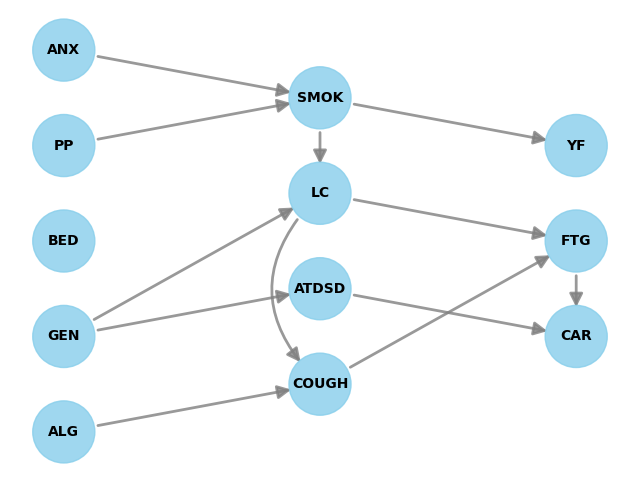

In [8]:
from IPython.display import Image, display

gml_graph = gml_to_string('lung_cancer_graph.gml')
# With GML string
model=CausalModel(
    data = data,
    treatment='COUGH',
    outcome='FTG',
    graph=gml_graph
)
model.view_model()

## 1. Find adj sets using DOwhy

In [9]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
────────(E[FTG|LC])
d[COUGH]           
Estimand assumption 1, Unconfoundedness: If U→{COUGH} and U→FTG then P(FTG|COUGH,LC,U) = P(FTG|COUGH,LC)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                             -1⎤
 ⎢  d         ⎛  d            ⎞  ⎥
E⎢──────(FTG)⋅⎜──────([COUGH])⎟  ⎥
 ⎣d[ALG]      ⎝d[ALG]         ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→FTG then ¬(U →→{ALG})
Estimand assumption 2, Exclusion: If we remove {ALG}→{COUGH}, then ¬({ALG}→FTG)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



####  Dowhy found:

1. Lung Cuncer as adj set with backdoor 
2. Allergy as instrumental variable 

## 2. Find adj set by hand

### 2.1 Backdoor


The backdoor criterion allows us to identify the variables on which we need to condition to calculate our causal estimates. We identify these variables by looking at 'backdoor' paths from the treatment variable.

Given a CBN $(G = (\mathbf{V}, \mathbf{E}), p)$ and a distinct pair of variables $X_i, Y_j \in \mathbf{V}$, a set $\mathbf{Z} \subseteq \mathbf{V} \setminus \{i,j\}$ satisfies the
**backdoor criterion** for estimating the causal effect of $X_i$ on $X_j$ if:
- $\mathbf{Z}$ does not contain any descendant of $i$, $Desc(i) \cap \mathbf{Z} = \emptyset$, **and**
- $\mathbf{Z}$ blocks all backdoor paths from $i$ to $j$ (all paths that start with an arrow into $i \gets ... j$)



In [10]:
## Descendants of COUGH

nx.descendants(G,'COUGH') | {'COUGH'}

{'CAR', 'COUGH', 'FTG'}

Z should not contain :

{'CAR', 'COUGH', 'FTG'}

In [11]:
H = G.to_undirected()
all_possible_paths = list(nx.all_simple_paths(H, 'COUGH', 'FTG'))
for path in all_possible_paths:
    print(path)

['COUGH', 'LC', 'GEN', 'ATDSD', 'CAR', 'FTG']
['COUGH', 'LC', 'FTG']
['COUGH', 'FTG']


Possible backdoor paths from COUGHING to FATIGUE : 

1. ['COUGH', 'LC', 'GEN', 'ATDSD', 'CAR', 'FTG']
2. ['COUGH', 'LC', 'FTG']

Check if backdoor paths are blocked :

In [12]:
adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])

path = ['COUGH', 'LC', 'GEN', 'ATDSD', 'CAR', 'FTG']

colliders = np.array([])
non_colliders = []
path_len = len(path)

# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()

# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 

adjustment_variables

,path,colliders,non_colliders
0,"[COUGH, LC, GEN, ATDSD, CAR, FTG]",[CAR],"[LC, GEN, ATDSD]"


#### Path [COUGH, LC, GEN, ATDSD, CAR, FTG] is blocked by CAR !


In [13]:
adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])

path = ['COUGH', 'LC', 'FTG']

colliders = np.array([])
non_colliders = []
path_len = len(path)

# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()

# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 

adjustment_variables

C:\Users\Ioannis\AppData\Local\Temp\ipykernel_20348\1845410062.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  non_colliders = [x for x in path[1:-1] if x not in colliders]


,path,colliders,non_colliders
0,"[COUGH, LC, FTG]",[],[LC]


Path [COUGH, LC, FTG] is unblocked as there are no colliders. We use LC to block it
Z = {$LC$}.
$\mathbf{Z}$ does not contain any descendant of $i$, $Desc(i) \cap \mathbf{Z} = \emptyset$.

Z = {$LC$} meets all conditions of backdoor criterion

### 2.2 Frontdoor Criterion


A set of variables **Z** is said to satisfy the front-door criterion relative to an ordered pair of variables ($X_i$, $X_j$), if:
1. **Z** intercepts all directed paths from $X_i$ to $X_j$
2. There is no unblocked backdoor path from $X_i$ to **Z**
3. All backdoor paths from **Z** to $X_j$ are blocked by $X_i$


There is no set M that blocks paths from Coughing to Fatigue. No frontdoor.

### 2.3 Instrumental variables

Instrumental variables can be used when you have unobserved confounders, limiting your ability to apply backdoor or frontdoor criterion. In order for a variable $Z$ to qualify as an instrumental variable for measuring the effect of $X$ on $Y$, it needs to meet the following conditions<sup>[1]</sup>:
1. $Z$ has a causal effect on $X$
2. $Z$ affects the outcome $Y$ only through $X$
3. $Z$ and $Y$ have no common causes

In order for a variable Allergy  to qualify as an instrumental variable for measuring the effect of Coughing  on Fatigue, it needs to meet the following conditions:

1. Allergy has a causal effect on Coughing.

2. Allergy affects the outcome Fatigue only through Coughing

3.  Allergy and Fatigue have no common causes


As it meets all conditions, we can use 'Allergy' as an instrumental variable.


## 3. Make biased linear estimation using linear regression

In [14]:
v0_vals = data['COUGH'].values.reshape(num_samples, 1)
y_vals = data['FTG'].values.reshape(num_samples, 1)

In [15]:
linear_regressor = LinearRegression() 
linear_regressor.fit(v0_vals, y_vals)
linear_regressor.coef_

array([[0.44200005]])

## 4. Make unbiased estimations 

### 4.1 Use Linear regression and adj set Z = {$LC$} from Backdooor

In [16]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
────────(E[FTG|LC])
d[COUGH]           
Estimand assumption 1, Unconfoundedness: If U→{COUGH} and U→FTG then P(FTG|COUGH,LC,U) = P(FTG|COUGH,LC)

## Realized estimand
b: FTG~COUGH+LC
Target units: ate

## Estimate
Mean value: 0.353209278697819

Causal Estimate is 0.353209278697819


### 4.1 Use Linear regression and adj set Z = {$ALG$} from IV

In [17]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="iv.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                             -1⎤
 ⎢  d         ⎛  d            ⎞  ⎥
E⎢──────(FTG)⋅⎜──────([COUGH])⎟  ⎥
 ⎣d[ALG]      ⎝d[ALG]         ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→FTG then ¬(U →→{ALG})
Estimand assumption 2, Exclusion: If we remove {ALG}→{COUGH}, then ¬({ALG}→FTG)

## Realized estimand
b: FTG~COUGH+LC
Target units: ate

## Estimate
Mean value: 0.353209278697819

Causal Estimate is 0.353209278697819


## Use inverse propensity weighting using backdoot adj set Z = {$LC$}

In [18]:
t_group = data[data["COUGH"]==1]
c_group = data[data["COUGH"]==0]

In [19]:
treatment_group_LC_0 = t_group[t_group["LC"]==0]
treatment_group_LC_1 = t_group[t_group["LC"]==1]

control_group_LC_0 = c_group[c_group["LC"]==0]
control_group_LC_1 = c_group[c_group["LC"]==1]

In [20]:
LC_0_group = pd.concat([treatment_group_LC_0,control_group_LC_0])
LC_1_group = pd.concat([treatment_group_LC_1,control_group_LC_1])

In [21]:
propensity_score_LC_0 = len(treatment_group_LC_0)/len(LC_0_group)
propensity_score_LC_1 = len(treatment_group_LC_1)/len(LC_1_group)

In [22]:
number_of_all_samples = num_samples

weighted_sum_treatment_0 = sum(treatment_group_LC_0["FTG"])/ propensity_score_LC_0
weighted_sum_treatment_1 = sum(treatment_group_LC_1["FTG"])/ propensity_score_LC_1


mean_treatment2 = weighted_sum_treatment_0 + weighted_sum_treatment_1 
mean_treatment2 = mean_treatment2/number_of_all_samples

weighted_sum_control_0 = sum(control_group_LC_0["FTG"])/(1 - propensity_score_LC_0)
weighted_sum_control_1 = sum(control_group_LC_1["FTG"])/ (1 - propensity_score_LC_1)

mean_control2 = weighted_sum_control_0 + weighted_sum_control_1 
mean_control2 = mean_control2/number_of_all_samples

ATE_IPW2 = mean_treatment2-mean_control2
print("ATE after IPW:", ATE_IPW2)

ATE after IPW: 0.3507998093204841


## Question 2: Average Causal Effect of Lung Cancer on Car Accident

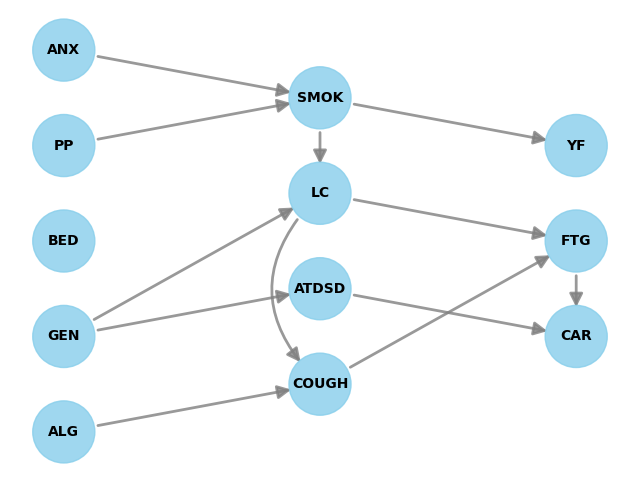

In [23]:
from IPython.display import Image, display

gml_graph = gml_to_string('lung_cancer_graph.gml')
# With GML string
model=CausalModel(
    data = data,
    treatment='LC',
    outcome='CAR',
    graph=gml_graph
)
model.view_model()

## Use DoWhy

In [24]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[CAR|GEN])
d[LC]            
Estimand assumption 1, Unconfoundedness: If U→{LC} and U→CAR then P(CAR|LC,GEN,U) = P(CAR|LC,GEN)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                            -1⎤
 ⎢   d         ⎛   d         ⎞  ⎥
E⎢───────(CAR)⋅⎜───────([LC])⎟  ⎥
 ⎣d[SMOK]      ⎝d[SMOK]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→CAR then ¬(U →→{SMOK})
Estimand assumption 2, Exclusion: If we remove {SMOK}→{LC}, then ¬({SMOK}→CAR)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡      d              ∂                ⎤
E⎢─────────────(CAR)⋅─────([FTG  COUGH])⎥
 ⎣d[FTG  COUGH]      ∂[LC]              ⎦
Estimand assumption 1, Full-mediation: FTG,COUGH intercepts (blocks) all directed paths from LC to C,A,R.
Estimand assumption 2, First-stage-unconfoundedness: If U→{LC} and U→{FTG,COUGH} then P(FTG,COUGH|LC,U) =

## Backdoor By Hand

In [25]:
## Descendants of COUGH

nx.descendants(G,'LC') | {'LC'}

{'CAR', 'COUGH', 'FTG', 'LC'}

In [26]:
H = G.to_undirected()

all_possible_paths = list(nx.all_simple_paths(H, 'LC', 'CAR'))
for path in all_possible_paths:
    print(path)

['LC', 'GEN', 'ATDSD', 'CAR']
['LC', 'FTG', 'CAR']
['LC', 'COUGH', 'FTG', 'CAR']


Possible backdoor paths:

['LC', 'GEN', 'ATDSD', 'CAR']

In [27]:
adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])

path = ['LC', 'GEN', 'ATDSD', 'CAR']

colliders = np.array([])
non_colliders = []
path_len = len(path)

# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()

# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 

adjustment_variables

C:\Users\Ioannis\AppData\Local\Temp\ipykernel_20348\2250918761.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  non_colliders = [x for x in path[1:-1] if x not in colliders]


,path,colliders,non_colliders
0,"[LC, GEN, ATDSD, CAR]",[],"[GEN, ATDSD]"


There are no colliders on this path, so we need to condition on at least one of Z = {$GEN$}, {$ATDSD$}, {$GEN$,$ATDSD$}


$\mathbf{Z}$ does not contain any descendant of $LC$, $Desc(LC) \cap \mathbf{Z} = \emptyset$.

Z = {$GEN$} or Z = {$ATDSD$} or Z = {$GEN$,$ATDSD$} meets all conditions of backdoor criterion

### FrontDoor By hand

Frontdoor Criterion


A set of variables **Z** is said to satisfy the front-door criterion relative to an ordered pair of variables ($X_i$, $X_j$), if:
1. **Z** intercepts all directed paths from $X_i$ to $X_j$
2. There is no unblocked backdoor path from $X_i$ to **Z**
3. All backdoor paths from **Z** to $X_j$ are blocked by $X_i$

1. Directed Paths from LC TO CAR

['LC', 'FTG', 'CAR']
['LC', 'COUGH', 'CAR']

Possible adj set Z = {$FTG$, $COUGH$ }

2. There is no unblocked backdoor path from  LC  to Z

Backdoor Paths : from LC to Z

['LC', 'GEN', 'ATDSD', 'CAR' 'Z']

Path is blocked by 'CAR'

3. All backdoor paths from Z to CAR are blocked by  LC

Backdoor Paths from Z to CAR:

['Z','LC','GEN','ATDSD','CAR']

Path blocked by LC

Z = {$FTG$, $COUGH$ } meets all criterion for frontdoor

### Biased Linear estimation

In [44]:
v0_vals = data['LC'].values.reshape(num_samples, 1)
y_vals = data['CAR'].values.reshape(num_samples, 1)

In [45]:
linear_regressor = LinearRegression() 
linear_regressor.fit(v0_vals, y_vals)
linear_regressor.coef_

array([[0.1684875]])

### Frontdoor 

In [46]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="frontdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: frontdoor
Estimand expression:
 ⎡      d              ∂                ⎤
E⎢─────────────(CAR)⋅─────([FTG  COUGH])⎥
 ⎣d[FTG  COUGH]      ∂[LC]              ⎦
Estimand assumption 1, Full-mediation: FTG,COUGH intercepts (blocks) all directed paths from LC to C,A,R.
Estimand assumption 2, First-stage-unconfoundedness: If U→{LC} and U→{FTG,COUGH} then P(FTG,COUGH|LC,U) = P(FTG,COUGH|LC)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{FTG,COUGH} and U→CAR then P(CAR|FTG,COUGH, LC, U) = P(CAR|FTG,COUGH, LC)

## Realized estimand
b: CAR~LC+GEN+LC*ALG+LC*ATDSD
Target units: 

## Estimate
Mean value: 0.15367946449068848
### Conditional Estimates
__categorical__ALG  __categorical__ATDSD
(-0.001, 1.0]       (-0.001, 1.0]           0.153679
dtype: float64
Causal Estimate is 0.15367946449068848


In [47]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="iv.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                            -1⎤
 ⎢   d         ⎛   d         ⎞  ⎥
E⎢───────(CAR)⋅⎜───────([LC])⎟  ⎥
 ⎣d[SMOK]      ⎝d[SMOK]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→CAR then ¬(U →→{SMOK})
Estimand assumption 2, Exclusion: If we remove {SMOK}→{LC}, then ¬({SMOK}→CAR)

## Realized estimand
b: CAR~LC+GEN+LC*ALG+LC*ATDSD
Target units: 

## Estimate
Mean value: 0.15367946449068848
### Conditional Estimates
__categorical__ALG  __categorical__ATDSD
(-0.001, 1.0]       (-0.001, 1.0]           0.153679
dtype: float64
Causal Estimate is 0.15367946449068848


## IPW with Backdoor adj set Z = ['ATDSD']

In [32]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="iv.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                            -1⎤
 ⎢   d         ⎛   d         ⎞  ⎥
E⎢───────(CAR)⋅⎜───────([LC])⎟  ⎥
 ⎣d[SMOK]      ⎝d[SMOK]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→CAR then ¬(U →→{SMOK})
Estimand assumption 2, Exclusion: If we remove {SMOK}→{LC}, then ¬({SMOK}→CAR)

## Realized estimand
b: CAR~LC+GEN+LC*ALG+LC*ATDSD
Target units: 

## Estimate
Mean value: 0.15367946449068848
### Conditional Estimates
__categorical__ALG  __categorical__ATDSD
(-0.001, 1.0]       (-0.001, 1.0]           0.153679
dtype: float64
Causal Estimate is 0.15367946449068848


# 5. Causal Discovery

In [37]:
from itertools import combinations

import cdt
# cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.3.3/bin/Rscript' # for Windows, here you may need to adjust the path based on your R Version

from dowhy import CausalModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.random import normal
import pandas as pd
import pingouin as pg
import dowhy.graph_learners.ges as dowhy_ges
import ges

alpha = 0.05 # significance level

## 5.1 Constraint-based Causal Discovery

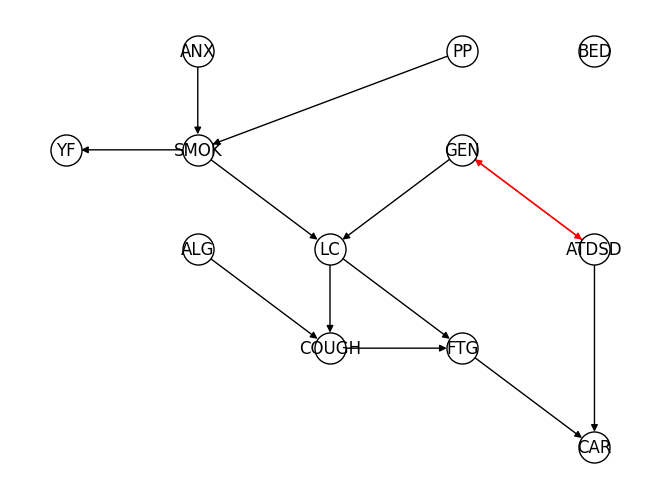

In [48]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
pc_graph = pc.create_graph_from_data(data)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

## 5.2 Score-based Causal Discovery

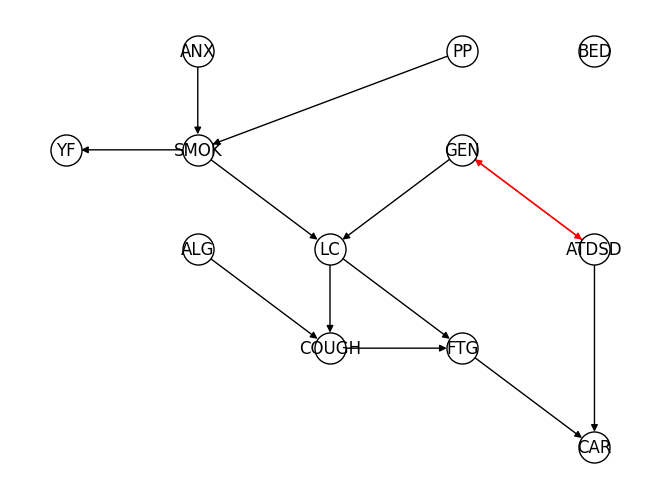

In [49]:
result, score = ges.fit_bic(data.to_numpy()) # The result is a CPDAG represented by an adjacency matrix
ges_graph = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(data.columns)})
colors = ['red'  if (y,x) in ges_graph.edges() else 'black' for (x,y) in ges_graph.edges()]
nx.draw(ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

### Remarks

- Both methods (PC and GES) arrive at the same causal graph
- Almost all of the causal relations agree with the graph provided in the dataset description, apart from the causal relation between Genetics and Attention Disorder, as the orientation of the edge could not be determined.
- It could be argued that, since Genetics are defined before birth and cannot be changed thereafter, the attention disorder of a human cannot possibly affect Genetics. Thus, the direction of the edge between Genetics and Attention Disorder could be provided as Background Knowledge (even backed by literature, for example: https://www.nature.com/articles/s41380%E2%80%90018%E2%80%900070%E2%80%900)

Applying techniques to test whether the estimate is accurate when adding in noise, downsampling, etc.

In [53]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(res_random)


Refute: Add a random common cause
Estimated effect:0.15367946449068848
New effect:0.15364229677634073
p value:0.9199999999999999



Testing the validity of our estimate by replacing the treatment with a placebo.

In [52]:
causal_refute_placebo_treatment = model.refute_estimate(
                                    identified_estimand ,
                                    causal_estimate,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )

print(causal_refute_placebo_treatment)


Refute: Use a Placebo Treatment
Estimated effect:0.15367946449068848
New effect:0.002277270679809391
p value:0.8600000000000001

